In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os  #폴더경로 생성하기 위해서 사용함 !
from tensorflow.keras.preprocessing.image import ImageDataGenerator #입력데이터 처리
from tensorflow.keras.applications  import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation # activation하기 전에 드렁가야 함 !
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import warnings #경고 메세지 창을 징귀
warnings.filterwarnings('ignore') #경고 메세지 창을 무시하기 

In [41]:
train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'
test_dir = './data/cat_dog_small/test'


#ImageDataGenerator 를 생성, 2개 필요 ->  어떤식으로 데이터를 가죠올 거니? 
#trian 1개 ->증식설정 필요/ Validation 1게 -> 증식 필요없음
train_datagen=ImageDataGenerator(rescale=1/255,
                                rotation_range=30,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                 vertical_flip=False,
                                fill_mode='nearest') # 변경하고 남은 부분을 근처와 비슷하게 채워라
                                # vertical_flit=True) # 위아래 위치를 바꿈 (사용 안하는거 추천!)  

validation_datagen=ImageDataGenerator(rescale=1/255)

#이미지 데이터 generator설정 잡기
train_generator =train_datagen.flow_from_directory(train_dir,
                                                  classes=['cats','dogs'],
                                                  target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary')
validation_generator=validation_datagen.flow_from_directory(validation_dir,
                                                           classes=['cats','dogs'],
                                                           target_size=(150,150),
                                                           batch_size=20,
                                                           class_mode='binary')




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [66]:
#model구현
model_base=VGG16(weights='imagenet',
                input_shape=(150,150,3),
                include_top=False)

#model_base에 대해서 False로 해서 filter값을 변경하지 않게 함(동결)
model_base_trainable=False
model=Sequential()
#hiddne layer
model.add(model_base) #내가 만든 model에 앞부분 filter에 model_base가 들어간다 이말임! -> 4차원
model.add(Flatten())  #위에 4차원을 1차원으로 만들어줌 ! : Flattne으 역활
model.add(Dense(units=128))
model.add(BatchNormalization()) #성능 향상을위해 사용함!
model.add(Activation('relu'))

model.add(Dropout(rate=0.2)) #무조건 activation두이 넣어야 함 !!! -> batchnomal이 있으니간 0.2정도만 
#output lyaer

model.add(Dense(units=1,
                activation='sigmoid'))
model.summary()





Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_17 (Flatten)        (None, 8192)              0         
                                                                 
 dense_19 (Dense)            (None, 128)               1048704   
                                                                 
 batch_normalization_17 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 activation_14 (Activation)  (None, 128)               0         
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                     

In [98]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(optimizer=Adam(learning_rate=1e-4),
             loss='binary_crossentropy', 
             metrics=['accuracy'])
call=EarlyStopping(patience=5,
                  monitor='val_loss',
                  verbose=1,
                  restore_best_weights=True) #그떄까지 가장 좋은 값 return 

check=ModelCheckpoint(filepath='./fintune.weights.h5',
                     save_best_only=True,
                     save_weights_only=True,
                     monitor='val_accuracy',
                     verbose=1)

history=model.fit(train_generator,
                  steps_per_epoch=100,
                  epochs=30,
                  validation_data=validation_generator,
                  validation_steps=50,
                  verbose=1,
                  callbacks=[call, check]
                  )
                  
                  

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9765  
Epoch 1: val_accuracy improved from -inf to 0.95100, saving model to ./fintune.weights.h5
100/100 [==============================] - 10s 87ms/step - loss: 0.0663 - accuracy: 0.9765 - val_loss: 0.1498 - val_accuracy: 0.9510
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9735 
Epoch 2: val_accuracy improved from 0.95100 to 0.95400, saving model to ./fintune.weights.h5
100/100 [==============================] - 9s 87ms/step - loss: 0.0731 - accuracy: 0.9735 - val_loss: 0.1239 - val_accuracy: 0.9540
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9745 
Epoch 3: val_accuracy improved from 0.95400 to 0.95900, saving model to ./fintune.weights.h5
100/100 [==============================] - 9s 86ms/step - loss: 0.0661 - accuracy: 0.9745 - val_loss: 0.1318 - val_accuracy: 0.9590
Epoch 4/30
100/100 [===============

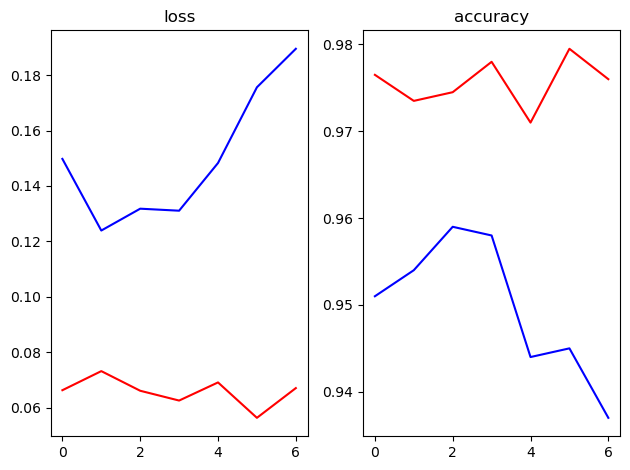

In [99]:
fig=plt.figure()
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.set_title('loss')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')


ax2.set_title('accuracy')
ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

fig.tight_layout()
plt.show()

In [117]:
#fine tuning(미세 조정) 상위 filter부분의 이용해서 좀 더 나에게 맞는 모델을 만듬
#어떻게 얼마나 뒤에 filter을 손봐야 하는가 -> 대략 20% 정도 
#학습을 한 상태에서 이걸 하고 다시 모델을 학습함!
%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os  #폴더경로 생성하기 위해서 사용함 !
from tensorflow.keras.preprocessing.image import ImageDataGenerator #입력데이터 처리
from tensorflow.keras.applications  import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation # activation하기 전에 드렁가야 함 !
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings #경고 메세지 창을 징귀
warnings.filterwarnings('ignore') #경고 메세지 창을 무시하기 
train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'
test_dir = './data/cat_dog_small/test'


#ImageDataGenerator 를 생성, 2개 필요 ->  어떤식으로 데이터를 가죠올 거니? 
#trian 1개 ->증식설정 필요/ Validation 1게 -> 증식 필요없음
train_datagen=ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest') # 변경하고 남은 부분을 근처와 비슷하게 채워라
                                # vertical_flit=True) # 위아래 위치를 바꿈 (사용 안하는거 추천!)  

validation_datagen=ImageDataGenerator(rescale=1/255)

#이미지 데이터 generator설정 잡기
train_generator =train_datagen.flow_from_directory(train_dir,
                                                  classes=['cats','dogs'],
                                                  target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary')
validation_generator=validation_datagen.flow_from_directory(validation_dir,
                                                           classes=['cats','dogs'],
                                                           target_size=(150,150),
                                                           batch_size=20,
                                                           class_mode='binary')


#model구현
model_base=VGG16(weights='imagenet',
                input_shape=(150,150,3),
                include_top=False)

#model_base에 대해서 False로 해서 filter값을 변경하지 않게 함(동결)
model_base_trainable=False
model=Sequential()
#hiddne layer
model.add(model_base) #내가 만든 model에 앞부분 filter에 model_base가 들어간다 이말임! -> 4차원
model.add(Flatten())  #위에 4차원을 1차원으로 만들어줌 ! : Flattne으 역활
model.add(Dense(units=128))
model.add(BatchNormalization()) #성능 향상을위해 사용함!
model.add(Activation('relu'))

model.add(Dropout(rate=0.2)) #무조건 activation두이 넣어야 함 !!! -> batchnomal이 있으니간 0.2정도만 
#output lyaer

model.add(Dense(units=1,
                activation='sigmoid'))



model.compile(optimizer=Adam(learning_rate=1e-4),
             loss='binary_crossentropy', 
             metrics=['accuracy'])

call=EarlyStopping(patience=5,
                  monitor='val_loss',
                  verbose=1,
                  restore_best_weights=True) #그떄까지 가장 좋은 값 return 

check=ModelCheckpoint(filepath='./f.weights.h5',
                     save_best_only=True,
                     save_weights_only=True,
                     monitor='val_accuracy',
                     verbose=1)

model.fit(train_generator,
          steps_per_epoch=100,
          epochs=30,
          validation_data=validation_generator,
          validation_steps=50,
          verbose=1,
          callbacks=[call,check])
                  
                  


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.7290  
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./fintunes.weights.h5
100/100 [==============================] - 15s 119ms/step - loss: 0.5561 - accuracy: 0.7290 - val_loss: 3.7673 - val_accuracy: 0.5000
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.8340 
Epoch 2: val_accuracy improved from 0.50000 to 0.62400, saving model to ./fintunes.weights.h5
100/100 [==============================] - 11s 114ms/step - loss: 0.3990 - accuracy: 0.8340 - val_loss: 1.2642 - val_accuracy: 0.6240
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.8635 
Epoch 3: val_accuracy improved from 0.62400 to 0.91900, saving model to ./fintunes.weights.h5
100/100 [==============================] - 12s 115ms/step - loss: 0.3115 - ac

KeyboardInterrupt: 

In [79]:
###여기에서 fine tuning작업이 필요함 !
#현재 동결된 layer중 20%  해제 해야함!
model_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
model_base.trainable=True
for layer in model_base.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable=True
    else:
        layer.trainable=False
#모델을 다시 compile해줘야함 !
model.compile(optimizer=Adam(learning_rate=1e-1),
             loss='binary_crossentropy', 
             metrics=['accuracy'])
model_base.summary()
call=EarlyStopping(patience=5,
                  monitor='val_loss',
                  verbose=1,
                  restore_best_weights=True) #그떄까지 가장 좋은 값 return 

check=ModelCheckpoint(filepath='./fintunesd.weights.h5',
                     save_best_only=True,
                     save_weights_only=True,
                     monitor='val_accuracy',
                     verbose=1)

history=model.fit(train_generator,
          steps_per_epoch=100,
          epochs=15,
          validation_data=validation_generator,
          validation_steps=50,
          verbose=1,
          callbacks=[call,check]
                  )



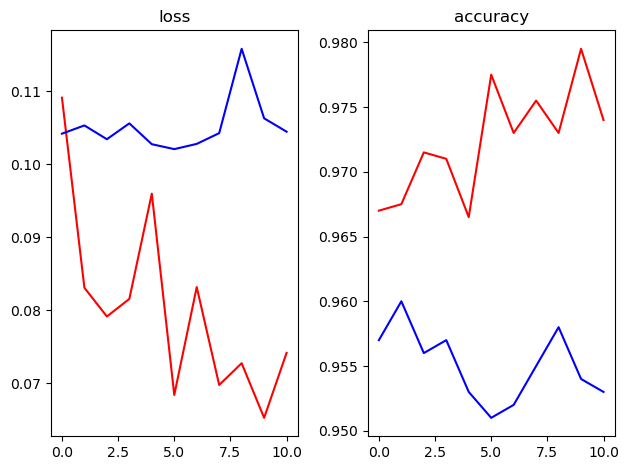

In [105]:
fig=plt.figure()
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.set_title('loss')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')


ax2.set_title('accuracy')
ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

fig.tight_layout()
plt.show()

In [107]:
#test데이터를 통해서 정확도 확인하기 
test_dir='data/cat_dog_small/test'
test_datagen=ImageDataGenerator(rescale=1/255,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

test_generator=test_datagen.flow_from_directory(
    test_dir,
    classes=['cats','dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)


Found 1001 images belonging to 2 classes.


In [108]:
loss, accuracy = model.evaluate(test_generator)

# 평가 결과 출력
print('Test Loss:', loss)  # 손실 값 출력
print('Test Accuracy:', accuracy)  # 정확도 출력

result=model.evaluate(test_generator)
print(result)


51/51 [==============================] - 4s 70ms/step - loss: 0.4283 - accuracy: 0.8192
Test Loss: 0.4282929599285126
Test Accuracy: 0.8191808462142944
51/51 [==============================] - 3s 66ms/step - loss: 0.4252 - accuracy: 0.8322
[0.4251565933227539, 0.8321678042411804]


Once deleted, variables cannot be recovered. Proceed (y/[n])?  t=y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
100/100 [==============================] - 14s 110ms/step - loss: 0.6978 - accuracy: 0.5980 - val_loss: nan - val_accuracy: 0.5000


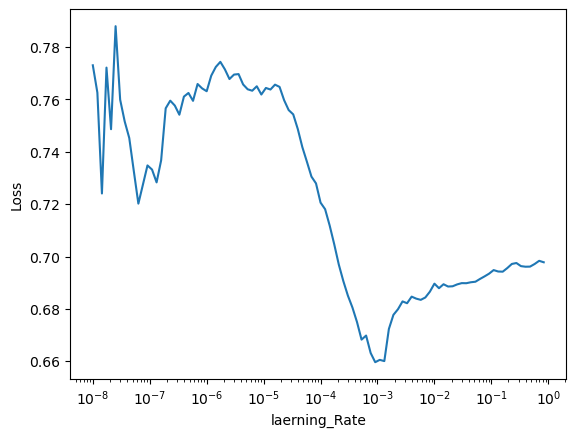

In [115]:
#optimizer의 값을 적절하게 변경해 주는 코드
#callback을 사용해서 최적화 
%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os  #폴더경로 생성하기 위해서 사용함 !
from tensorflow.keras.preprocessing.image import ImageDataGenerator #입력데이터 처리
from tensorflow.keras.applications  import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation # activation하기 전에 드렁가야 함 !
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings #경고 메세지 창을 징귀
warnings.filterwarnings('ignore') #경고 메세지 창을 무시하기 
train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'
test_dir = './data/cat_dog_small/test'


#ImageDataGenerator 를 생성, 2개 필요 ->  어떤식으로 데이터를 가죠올 거니? 
#trian 1개 ->증식설정 필요/ Validation 1게 -> 증식 필요없음
train_datagen=ImageDataGenerator(rescale=1/255)
                                # rotation_range=40,
                                # width_shift_range=0.1,
                                # height_shift_range=0.1,
                                # shear_range=0.2,
                                # zoom_range=0.2,
                                # horizontal_flip=True,
                                # fill_mode='nearest') # 변경하고 남은 부분을 근처와 비슷하게 채워라
                                # # vertical_flit=True) # 위아래 위치를 바꿈 (사용 안하는거 추천!)  

validation_datagen=ImageDataGenerator(rescale=1/255)

#이미지 데이터 generator설정 잡기
train_generator =train_datagen.flow_from_directory(train_dir,
                                                  classes=['cats','dogs'],
                                                  target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary')
validation_generator=validation_datagen.flow_from_directory(validation_dir,
                                                           classes=['cats','dogs'],
                                                           target_size=(150,150),
                                                           batch_size=20,
                                                           class_mode='binary')


#model구현
model_base=VGG16(weights='imagenet',
                input_shape=(150,150,3),
                include_top=False)

#model_base에 대해서 False로 해서 filter값을 변경하지 않게 함(동결)
model_base_trainable=False
model=Sequential()
#hiddne layer
model.add(model_base) #내가 만든 model에 앞부분 filter에 model_base가 들어간다 이말임! -> 4차원
model.add(Flatten())  #위에 4차원을 1차원으로 만들어줌 ! : Flattne으 역활
model.add(Dense(units=128))
model.add(BatchNormalization()) #성능 향상을위해 사용함!
model.add(Activation('relu'))

model.add(Dropout(rate=0.2)) #무조건 activation두이 넣어야 함 !!! -> batchnomal이 있으니간 0.2정도만 
#output lyaer

model.add(Dense(units=1,
                activation='sigmoid'))


init_learning =1e-8
model.compile(optimizer=Adam(learning_rate=init_learning),
             loss='binary_crossentropy', 
             metrics=['accuracy'])

#learning_rate 에 사용자 정의 callack 구하기 
class LRFinderCallback(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-8, max_lr=10, steps=100):
        self.min_lr=min_lr
        self.max_lr=max_lr
        self.total_steps=steps
        self.history={'lr':[],
                     'loss':[]}  #여기에 받아올 것임 
    def on_batch_end(self, batch, logs=None):
        lr=self.min_lr * (self.max_lr /self.min_lr)**(batch/self.total_steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.history['lr'].append(lr)
        self.history['loss'].append(logs['loss'])


learning_rate_find = LRFinderCallback(min_lr=1e-8, max_lr=1, steps=100)



model.fit(train_generator,
          steps_per_epoch=100,
          epochs=1,
          validation_data=validation_generator,
          validation_steps=50,
          verbose=1,
          callbacks=[learning_rate_find])
                  
                  


plt.plot(learning_rate_find.history['lr'],learning_rate_find.history['loss'] )
plt.xscale('log')
plt.xlabel('laerning_Rate')
plt.ylabel('Loss')
plt.show()




In [130]:
#다른 방법으로 알아보자 optuna를 통해 
import optuna

#optimizer의 값을 적절하게 변경해 주는 코드
#callback을 사용해서 최적화 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os  #폴더경로 생성하기 위해서 사용함 !
from tensorflow.keras.preprocessing.image import ImageDataGenerator #입력데이터 처리
from tensorflow.keras.applications  import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation # activation하기 전에 드렁가야 함 !
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings #경고 메세지 창을 징귀
warnings.filterwarnings('ignore') #경고 메세지 창을 무시하기 
train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'
test_dir = './data/cat_dog_small/test'


#ImageDataGenerator 를 생성, 2개 필요 ->  어떤식으로 데이터를 가죠올 거니? 
#trian 1개 ->증식설정 필요/ Validation 1게 -> 증식 필요없음
train_datagen=ImageDataGenerator(rescale=1/255)
                                # rotation_range=40,
                                # width_shift_range=0.1,
                                # height_shift_range=0.1,
                                # shear_range=0.2,
                                # zoom_range=0.2,
                                # horizontal_flip=True,
                                # fill_mode='nearest') # 변경하고 남은 부분을 근처와 비슷하게 채워라
                                # # vertical_flit=True) # 위아래 위치를 바꿈 (사용 안하는거 추천!)  

validation_datagen=ImageDataGenerator(rescale=1/255)

#이미지 데이터 generator설정 잡기
train_generator =train_datagen.flow_from_directory(train_dir,
                                                  classes=['cats','dogs'],
                                                  target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary')
validation_generator=validation_datagen.flow_from_directory(validation_dir,
                                                           classes=['cats','dogs'],
                                                           target_size=(150,150),
                                                           batch_size=20,
                                                           class_mode='binary')


#model구현
model_base=VGG16(weights='imagenet',
                input_shape=(150,150,3),
                include_top=False)

#model_base에 대해서 False로 해서 filter값을 변경하지 않게 함(동결)
model_base_trainable=False
model=Sequential()
#hiddne layer
model.add(model_base) #내가 만든 model에 앞부분 filter에 model_base가 들어간다 이말임! -> 4차원
model.add(Flatten())  #위에 4차원을 1차원으로 만들어줌 ! : Flattne으 역활
model.add(Dense(units=128))
model.add(BatchNormalization()) #성능 향상을위해 사용함!
model.add(Activation('relu'))

model.add(Dropout(rate=0.2)) #무조건 activation두이 넣어야 함 !!! -> batchnomal이 있으니간 0.2정도만 
#output lyaer

model.add(Dense(units=1,
                activation='sigmoid'))


def objective(trial):
    lr = trial.suggest_loguniform('learning_rate', 1e-7,1e-1)
    model.compile(optimizer=Adam(learning_rate=lr),
             loss='binary_crossentropy', 
             metrics=['accuracy'])
    history=model.fit(train_generator,
          steps_per_epoch=100,
          epochs=10,
          validation_data=validation_generator,
          validation_steps=50,
          verbose=1)
    return history.history['val_accuracy'][-1]

study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(f'최적의 파라미터 :'+study.best_parms['learning_rate'])

    




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


[I 2025-04-28 15:42:05,546] A new study created in memory with name: no-name-18def360-c6c7-4c67-839f-71f267ac2171


Epoch 1/10
100/100 [==============================] - 14s 111ms/step - loss: 0.5545 - accuracy: 0.7215 - val_loss: 3.7792 - val_accuracy: 0.5060
Epoch 2/10
100/100 [==============================] - 11s 109ms/step - loss: 0.4080 - accuracy: 0.8170 - val_loss: 0.9005 - val_accuracy: 0.6610
Epoch 3/10
100/100 [==============================] - 11s 109ms/step - loss: 0.3268 - accuracy: 0.8610 - val_loss: 0.6198 - val_accuracy: 0.7360
Epoch 4/10
100/100 [==============================] - 11s 111ms/step - loss: 0.2542 - accuracy: 0.8920 - val_loss: 0.3239 - val_accuracy: 0.8700
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 0.1935 - accuracy: 0.9260 - val_loss: 0.2676 - val_accuracy: 0.8890
Epoch 6/10
100/100 [==============================] - 11s 110ms/step - loss: 0.1381 - accuracy: 0.9465 - val_loss: 0.4804 - val_accuracy: 0.8030
Epoch 7/10
100/100 [==============================] - 11s 110ms/step - loss: 0.1166 - accuracy: 0.9560 - val_loss: 0.4202 - val_ac

[I 2025-04-28 15:43:59,028] Trial 0 finished with value: 0.7559999823570251 and parameters: {'learning_rate': 0.0001363265103574219}. Best is trial 0 with value: 0.7559999823570251.


Epoch 1/10
100/100 [==============================] - 14s 112ms/step - loss: 0.7033 - accuracy: 0.6035 - val_loss: 1.0716 - val_accuracy: 0.5170
Epoch 2/10
100/100 [==============================] - 11s 110ms/step - loss: 0.6171 - accuracy: 0.6605 - val_loss: 0.6716 - val_accuracy: 0.6050
Epoch 3/10
100/100 [==============================] - 11s 108ms/step - loss: 0.5971 - accuracy: 0.6900 - val_loss: 3.5190 - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 11s 109ms/step - loss: 0.5595 - accuracy: 0.7185 - val_loss: 0.9551 - val_accuracy: 0.5440
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 0.5220 - accuracy: 0.7490 - val_loss: 0.9271 - val_accuracy: 0.6140
Epoch 6/10
100/100 [==============================] - 11s 108ms/step - loss: 0.4810 - accuracy: 0.7840 - val_loss: 3.4504 - val_accuracy: 0.5000
Epoch 7/10
100/100 [==============================] - 11s 108ms/step - loss: 0.4434 - accuracy: 0.7985 - val_loss: 0.4593 - val_ac

[I 2025-04-28 15:45:50,887] Trial 1 finished with value: 0.6840000152587891 and parameters: {'learning_rate': 0.0008218444106687134}. Best is trial 0 with value: 0.7559999823570251.


Epoch 1/10
100/100 [==============================] - 14s 110ms/step - loss: 0.2813 - accuracy: 0.8905 - val_loss: 0.4261 - val_accuracy: 0.8050
Epoch 2/10
100/100 [==============================] - 11s 108ms/step - loss: 0.2573 - accuracy: 0.9035 - val_loss: 0.3632 - val_accuracy: 0.8290
Epoch 3/10
100/100 [==============================] - 11s 108ms/step - loss: 0.2633 - accuracy: 0.8990 - val_loss: 0.3530 - val_accuracy: 0.8340
Epoch 4/10
100/100 [==============================] - 11s 108ms/step - loss: 0.2500 - accuracy: 0.9005 - val_loss: 0.3481 - val_accuracy: 0.8370
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 0.2439 - accuracy: 0.9100 - val_loss: 0.3453 - val_accuracy: 0.8390
Epoch 6/10
100/100 [==============================] - 11s 108ms/step - loss: 0.2577 - accuracy: 0.9035 - val_loss: 0.3429 - val_accuracy: 0.8420
Epoch 7/10
100/100 [==============================] - 11s 108ms/step - loss: 0.2563 - accuracy: 0.9015 - val_loss: 0.3407 - val_ac

[I 2025-04-28 15:47:42,298] Trial 2 finished with value: 0.8450000286102295 and parameters: {'learning_rate': 4.186721050213119e-06}. Best is trial 2 with value: 0.8450000286102295.


Epoch 1/10
100/100 [==============================] - 14s 110ms/step - loss: 0.7438 - accuracy: 0.5405 - val_loss: 0.7695 - val_accuracy: 0.5080
Epoch 2/10
100/100 [==============================] - 11s 106ms/step - loss: 0.6962 - accuracy: 0.5705 - val_loss: 0.6857 - val_accuracy: 0.5540
Epoch 3/10
100/100 [==============================] - 11s 107ms/step - loss: 0.6853 - accuracy: 0.5805 - val_loss: 0.7493 - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 11s 107ms/step - loss: 0.6851 - accuracy: 0.5805 - val_loss: 0.7441 - val_accuracy: 0.5000
Epoch 5/10
100/100 [==============================] - 11s 108ms/step - loss: 0.6585 - accuracy: 0.5940 - val_loss: 2.0803 - val_accuracy: 0.5020
Epoch 6/10
100/100 [==============================] - 11s 110ms/step - loss: 0.6593 - accuracy: 0.6080 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/10
100/100 [==============================] - 11s 106ms/step - loss: 0.6935 - accuracy: 0.4980 - val_loss: nan - val_accuracy

[I 2025-04-28 15:49:32,346] Trial 3 finished with value: 0.5 and parameters: {'learning_rate': 0.011181625449601178}. Best is trial 2 with value: 0.8450000286102295.


Epoch 1/10
100/100 [==============================] - 14s 112ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 11s 108ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 11s 108ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 11s 106ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/10
100/100 [==============================] - 11s 106ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/10
100/100 [==============================] - 11s 105ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/10
100/100 [==============================] - 11s 107ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 

[I 2025-04-28 15:51:22,736] Trial 4 finished with value: 0.5 and parameters: {'learning_rate': 3.573930670885871e-05}. Best is trial 2 with value: 0.8450000286102295.


Epoch 1/10
100/100 [==============================] - 14s 108ms/step - loss: 0.6934 - accuracy: 0.4995 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6933 - accuracy: 0.4830 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6933 - accuracy: 0.4875 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 12s 115ms/step - loss: 0.6932 - accuracy: 0.4880 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/10
100/100 [==============================] - 12s 120ms/step - loss: 0.6932 - accuracy: 0.4845 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/10
100/100 [==============================] - 10s 103ms/step - loss: 0.6931 - accuracy: 0.4945 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/10
100/100 [==============================] - 10s 103ms/step - loss: 0.6934 - accuracy: 0.4870 - val_loss: nan - val_accuracy: 0.5000
Epoch 

[I 2025-04-28 15:53:12,981] Trial 5 finished with value: 0.5 and parameters: {'learning_rate': 0.0032353996880868765}. Best is trial 2 with value: 0.8450000286102295.


Epoch 1/10
100/100 [==============================] - 14s 107ms/step - loss: 0.6931 - accuracy: 0.5120 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6933 - accuracy: 0.4820 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 11s 105ms/step - loss: 0.6931 - accuracy: 0.5105 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6932 - accuracy: 0.4890 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/10
100/100 [==============================] - 11s 105ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: nan - val_accuracy: 0.5000
Epoch 

[I 2025-04-28 15:55:00,761] Trial 6 finished with value: 0.5 and parameters: {'learning_rate': 2.434075125076254e-05}. Best is trial 2 with value: 0.8450000286102295.


Epoch 1/10
100/100 [==============================] - 14s 107ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6932 - accuracy: 0.4880 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 11s 105ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/10
 55/100 [===============>..............] - ETA: 3s - loss: 0.6931 - accuracy: 0.5109 

[W 2025-04-28 15:55:50,656] Trial 7 failed with parameters: {'learning_rate': 4.177693912809059e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/eva/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1948/57749229.py", line 82, in objective
    history=model.fit(train_generator,
  File "/home/eva/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/home/eva/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/engine/training.py", line 1748, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/home/eva/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/callbacks.py", line 475, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, "end", batch, logs=logs)
  File "/home/eva/anaconda3/en

KeyboardInterrupt: 